### Epidemics on networks

Below is code for generating an animation of the network epidemic model in the textbook, using the default parameter settings — both the infection and recovery rates are 0.5.

Please **do not** try to analyze the `make_animation()` function below — it's not relevant to understanding the network model. It is however useful for generating animations inline in CoCalc / Jupyter notebooks, so feel free to reuse this code in your own work.

In [1]:
def make_animation(draw_function, frames, interval, filename=None,
                   verbose=False, figure_params=None):
    """
    Write an animated GIF to file using matplotlib and ImageMagick.

    Inputs:

        draw_function (callable) The function to call, once per frame,
          to render to the current matplotlib figure. This function's call
          signature must be

            draw_function(current_frame_number, total_frame_count)

          The first frame is 0 and the last frame is total_frame_count-1.

        frames (int) The number of frames to generate.

        interval (float) The number of milliseconds to wait between frames
          in the animation. Set this to 40 for a fairly standard frame rate
          of 25fps (1 second / 40 (milliseconds per frame) = 25 frames per
          second).

        filename (str) The path to the file to write to. If none is provided,
          the animation will be written to a random filename, prefixed with
          "animate_" in the current directory. Default: None.

        verbose (bool) Whether to print the current frame number to the
          console as the animation is being created. This will clear other
          console output. Default: False.

        figure_params (dict) The keyword arguments to pass to matplotlib
          when creating a new figure for this animation. Use it to set the
          figure size and other figure properties. Default: None.

    Returns: A display object that will inject HTML for displaying the
      animated GIF into the notebook.
    """
    from matplotlib import pyplot, animation
    from IPython.display import HTML, display, clear_output
    import random

    if filename is None:
        filename = 'animate_%06i.gif' % random.randint(0, 999999)
    # Create figure
    if figure_params is None:
        figure_params = {}
    figure = pyplot.figure(**figure_params)
    # Wrap draw_function if we need to print to console
    if verbose:
        old_draw_function = draw_function
        def draw_function(current_frame_number, total_frame_count):
            old_draw_function(current_frame_number, total_frame_count)
            print('Processed frame', current_frame_number + 1, '/', total_frame_count)
            clear_output(wait=True)
            if current_frame_number + 1 == total_frame_count:
                print('Writing animation to file...')
                clear_output(wait=True)
    # Generate animation
    anim = animation.FuncAnimation(
        figure, draw_function, frames=frames, interval=interval,
        init_func=lambda: None, fargs=(frames,))
    anim.save(filename, writer='imagemagick')
    # Close the animation figure so the last frame does not get displayed
    # in the notebook.
    pyplot.close()
    # Return display object for the animated GIF
    return display(HTML('<img src="' + filename + '">'))

### The simulation
The code below is cleaned up from the textbook with some extra code for generating a density plot. Run it to get an animation of the spread of the epidemic on the network. Generating these animations takes a bit of time, so please be patient.

In [100]:
import networkx as nx
from matplotlib import rc
import matplotlib.pyplot as plt

rc('font',**{'family':'serif','serif':['Computer Modern'],'size': 16})
rc('text', usetex=True)
import random


class SisSimulation:

    def __init__(self, p_i=0.5, p_r=0.5, randomize_graph=0.0):
        self.p_i = p_i  # infection probability
        self.p_r = p_r  # recovery probability
        self.randomize_graph = randomize_graph

    def initialize(self):
        self.graph = nx.connected_watts_strogatz_graph(30, 4, self.randomize_graph)
        self.graph_layout = nx.spring_layout(self.graph)
        for i in self.graph.nodes:
            self.graph.nodes[i]['infected'] = (
                1 if random.uniform(0, 1) < 0.5 else 0)
        self.time = 0
        self.density_history = []

    def observe(self):
        plt.cla()
        plt.subplot(1, 2, 1)
        nx.draw(
            self.graph, vmin = 0, vmax = 1,
            node_color = [self.graph.nodes[i]['infected'] for i in self.graph.nodes],
            cmap = 'bwr',
            pos = self.graph_layout)
        plt.title('Step: ' + str(self.time))
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(self.density_history) + 1), self.density_history)
        plt.ylim(0, 1)
        plt.title('Proportion of population infected')
        plt.show()

    def update(self):
        for _ in range(1000):
            a = random.choice(list(self.graph.nodes))
            if self.graph.nodes[a]['infected'] == 0:  # if susceptible
                b = random.choice(list(self.graph.neighbors(a)))
                if self.graph.nodes[b]['infected'] == 1:  # if neighbor b is infected
                    self.graph.nodes[a]['infected'] = 1 if random.uniform(0, 1) < self.p_i else 0
            else:  # if infected
                self.graph.nodes[a]['infected'] = 0 if random.uniform(0, 1) < self.p_r else 1
            self.time += 1
            self.density_history.append(sum(self.graph.nodes[i]['infected'] 
                                            for i in self.graph.nodes) / len(self.graph.nodes))
        return self.density_history[-1]

In [108]:
infection_probability = 0.8  # Probability of one neighbor infecting another
recovery_probability = 0.35  # Probability of recovery
graph_randomness = .5        # 0 => not random; 1 => very random; 0.5 => somewhat random.

sim = SisSimulation(infection_probability, recovery_probability, graph_randomness)
sim.initialize()

def animate_simulation(frame, total_frames):
    # To speed things up we avoid plotting after every simulation update
    steps_per_frame = 20
    for _ in range(steps_per_frame):
        sim.update()
    sim.observe()

make_animation(
    animate_simulation, frames=10, interval=250,
    figure_params={'figsize': (12, 5)},
    verbose=True)

In [42]:
val = [_/100 for _ in range(1,101)]
matrix_qi = []
for infec in val:
    for recov in val:
        sim = SisSimulation(infec, recov, 0)
        sim.initialize()
        result = sim.update()
        matrix_qi.append(result)
matrix_qii = np.array(matrix_qi)

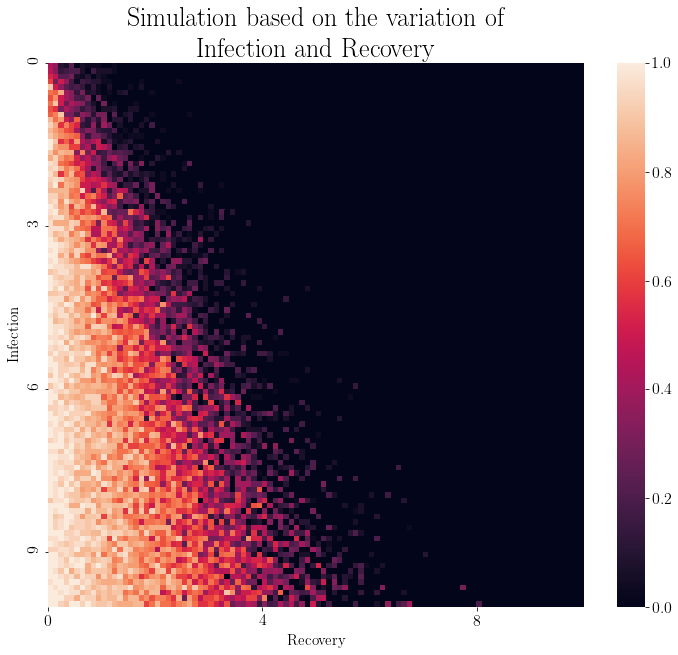

In [97]:
import seaborn as sns
plt.figure(figsize=(12, 10))
ax = sns.heatmap(matrix_qii.reshape((100,100)))
ax.set_yticks(np.arange(0, 100, step=30))
ax.set_xticks(np.arange(0, 100, step=40))
plt.title('Simulation based on the variation of \nInfection and Recovery',
         fontsize=26)
plt.xlabel('Recovery', fontsize=15)
plt.ylabel('Infection', fontsize=15)
plt.show()